<a href="https://colab.research.google.com/github/zarrinan/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module3-gradient-descent/U2_S2_D3_Gradient_Descent_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent Implementation Challenge!!

## Use gradient descent to find the optimal parameters of a **multiple** regression model. (We only showed an implementation for a bivariate model during lecture.)

A note: Implementing gradient descent in any context is not trivial, particularly the step where we calculate the gradient will change based on the number of parameters that we're trying to optimize for. You will need to research what the gradient of a multiple regression model looks like. This challenge is pretty open-ended but I hope it will be thrilling. Please work together, help each other, share resources and generally expand your understanding of gradient descent as you try and achieve this implementation. 

## Suggestions:

Start off with a model that has just two $X$ variables You can use any datasets that have at least two x variables. Potential candidates might be the blood pressure dataset that we used during lecture on Monday: [HERE](https://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/mlr/excel/mlr02.xls) or any of the housing datasets. You would just need to select from them the two varaibles $x$ variables and one y variable that you want to work with that you most want to work with. 

Use Sklearn to find the optimal parameters of your model first. (like we did during the lecture.) So that you can compare the parameter estimates of your gradient-descent linear regression to the estimates of OLS linear regression. If implemented correctly they should be nearly identical.

Becoming a Data Scientist is all about striking out into the unknown, getting stuck and then researching and fighting and learning until you get yourself unstuck. Work together! And fight to take your own learning-rate fueled step towards your own optimal understanding of gradient descent! 


###OSL

In [0]:
##### Make it Hap'n Cap'n #####

In [0]:
!pip install seaborn==0.9.0 -q

In [89]:
!pip install scipy

In [0]:
#IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import optimize

In [0]:
sns.__version__

In [0]:
raw = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv', index_col=0)
names =['MSSubClass', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice']
raw2 = raw[names].copy()

In [0]:
#Auto encodes any dataframe column of type category or object.
def dummy_encode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df
df = dummy_encode(raw2)

In [0]:
df['ln_price'] = np.log(df['SalePrice'])

In [75]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(998, 25)

In [0]:
df.columns
cols = ['OverallQual', 'GrLivArea']

In [77]:
#OSL
def print_rse_r2(df, target, cols):
  y = df.loc[:, [target]].values
  
  
  X = df.loc[:, cols].values
  # Slit into test and train datasets
  X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.25, random_state=42)

  # fit model using train datasets
  model = LinearRegression()
  model.fit(X_train, Y_train)

  # Create new predictions using x_test
  y_pred = model.predict(X_test)

  # Measure Accuracy using y_test and y_pred
  RMSE = (np.sqrt(mean_squared_error(Y_test, y_pred)))
  R2 = r2_score(Y_test, y_pred)

  print('RMSE is {}'.format(RMSE))
  print('R^2 is {}'.format(R2))
  print("coefficients: ", model.coef_[0])
  print("intercepts: ", model.intercept_)
  
print_rse_r2(df, 'SalePrice', cols)

RMSE is 25078.13025338941
R^2 is 0.779094318746662
coefficients:  [27071.05970445    53.86776355]
intercepts:  [-67996.22539912]


### Gradient Descent

<b>Cost</b>
\begin{equation}
J(\theta) = 1/2m \sum_{i=1}^{m} (h_\theta(x^{(i)} - y^{(i)})^2 
\end{equation}

<b>Gradient</b>

\begin{equation}
\frac{\partial J(\theta)}{\partial \theta_j} = 1/m\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)}).X_j^{(i)}
\end{equation}

<b>Gradients</b>
\begin{equation}
\theta_j: = \theta_j -\alpha . 1/m .\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)}).X_j^{(i)}
\end{equation}


In [0]:
### Define X and y variables
x = df[['OverallQual', 'GrLivArea']].values
X = df[['OverallQual', 'GrLivArea']].values
# Normalize X
X = (X - X.mean()) / X.std()
# Matrix version 
X = np.c_[np.ones((X.shape[0], 1)), X]

y = df['SalePrice'][:, np.newaxis]

In [0]:
class LinearRegressionUsingGD:
    """Linear Regression Using Gradient Descent.
    Parameters
    ----------
    eta : float
        Learning rate
    n_iterations : int
        No of passes over the training set
    Attributes
    ----------
    w_ : weights/ after fitting the model [theta]
    cost_ : total error of the model after each iteration
    """

    def __init__(self, eta=0.05, n_iterations=100):
        self.eta = eta
        self.n_iterations = n_iterations

    def fit(self, x, y):
        """Fit the training data
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Training samples
        y : array-like, shape = [n_samples, n_target_values]
            Target values
        Returns
        -------
        self : object
        """

        self.cost_ = [] 
        self.w_ = np.zeros((x.shape[1], 1)) #also, known as theta
        m = x.shape[0]

        for _ in range(self.n_iterations):
            y_pred = self.predict(X)
            residual = y_pred - y
            cost = np.sum((residual ** 2)) / (2 * m) #sse
            self.cost_.append(cost)
            
            gradient_vector = np.dot(X.T, residual) #𝑔𝑟𝑎𝑑𝑖𝑒𝑛𝑡=(−𝑋∗(𝑒𝑟𝑟𝑜𝑟𝑠))/𝑁
            
            self.w_ -= (self.eta / m) * gradient_vector

             
        return self

    def predict(self, x):
        """ Predicts the value after the model has been trained.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted value
        """
        return np.dot(x, self.w_)

In [109]:
gd = LinearRegressionUsingGD(eta=0.05, n_iterations=10000)
gd.fit(X,y)
gd.w_

array([[ 62727.87412894],
       [-41187.09329022],
       [ 78329.14455482]])

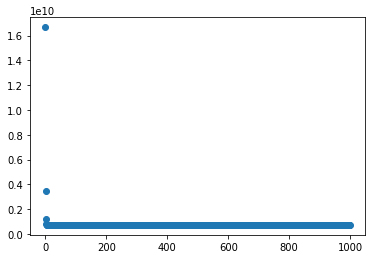

In [81]:
epochs = np.arange(len(gd.cost_))
plt.scatter(x=epochs, y=gd.cost_)
plt.show()


### Using scipy fmin_tnc function

In [0]:
def sigmoid(x):
    # Activation function used to map any real value between 0 and 1
    return 1 / (1 + np.exp(-x))

def net_input(theta, x):
    # Computes the weighted sum of inputs
    return np.dot(x, theta)

def probability(theta, x):
    # Returns the probability after passing through sigmoid
    return sigmoid(net_input(theta, x))

In [0]:
def cost_function(theta, x, y):
    # Computes the cost function for all the training samples
    m = x.shape[0]
    total_cost = -(1 / m) * np.sum(
        y * np.log(probability(theta, x)) + (1 - y) * np.log(
            1 - probability(theta, x)))
    return total_cost

def gradient(theta, x, y):
    # Computes the gradient of the cost function at the point theta
    m = x.shape[0]
    return (1 / m) * np.dot(x.T, sigmoid(net_input(theta,   x)) - y)

In [44]:
def fit( x, y, theta):
    opt_weights = optimize.fmin_tnc(func=cost_function, x0=theta,
                  fprime=gradient,args=(x, y.flatten()))
    return opt_weights[0]
parameters = fit(X, y, theta)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [0]:
print(parameters)

[ 6.03199181 -5.60816309  5.67129453]


### Another approach

In [0]:
def gradient_descent(X, y, iterations, alpha):
    """
    gradient descent regression
 
    X = features, np.array
    y = target, np.array
    iterations = steps taken to converge
    alpha = learning rate
    """
    X_norm = (X - X.mean()) / X.std()
    X_linalg = np.c_[np.ones(X_norm.shape[0]), X_norm]
    
    theta = np.zeros((X_linalg.shape[1], 1)) #initial guess for theta (weights) are zeros
    
    for _ in range(iterations):
        pred = np.dot(X_linalg, theta)
        error = pred - y
        gradient = np.dot(X_linalg.T, error) / len(y)
        theta = theta - alpha*gradient
    
    return theta, pred

In [0]:
theta, pred = gradient_descent(x, y, 10000, 0.05)
theta

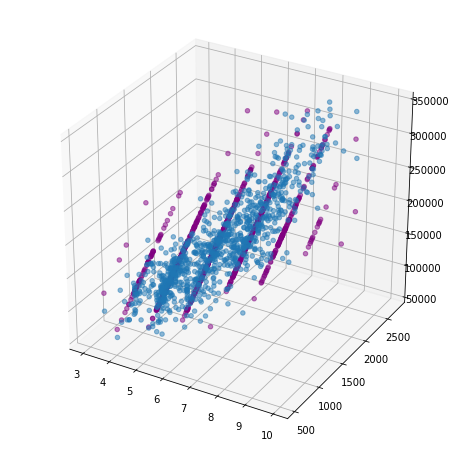

In [120]:
# ### Plotting
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')

# # Plot datapoints
# ax.scatter(x[:,0], x[:,1], y, alpha=0.5);
# ax.scatter(x[:,0], x[:,1], pred, alpha=0.5, color='purple');



## Stretch Goals

If you happen upon the most useful resources for accomplishing this challenge first, I want you to spend time today studying other variations of Gradient Descent-Based Optimizers.

- Try and write a function that can perform gradient descent for arbitarily large (in dimensionality) multiple regression models. 
- Create a notebook for yourself exploring these topics
- How do they differ from the "vanilla" gradient descent we explored today
- How do these different gradient descent-based optimizers seek to overcome the challenge of finding the global minimum among various local minima?
- Write a blog post that reteaches what you have learned about these other gradient descent-based optimizers.

[Overview of GD-based optimizers](http://ruder.io/optimizing-gradient-descent/)

[Siraj Raval - Evolution of Gradient Descent-Based Optimizers](https://youtu.be/nhqo0u1a6fw)